Make sure to select the conda base kernel

In [32]:
from skimage import io, img_as_ubyte
from skimage.filters import gaussian
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
os.getcwd()

'/Users/elizabeth 1/Library/CloudStorage/Box-Box/Wu Lab/Project - statin/0.1. MSSR/Elizabeth (Github Repository)/MSSR-Statin-Project/scripts'

In [3]:
# filenames are structured with '_w1', '_w2', '_w3' to indicate channels.
directory = '/Users/elizabeth 1/Library/CloudStorage/Box-Box/Wu Lab/Project - 2024/Functional screening/240411 test in 6-well/Moe Effciency_Plate_1252/TimePoint_1'
output_directory = '/Users/elizabeth 1/Library/CloudStorage/Box-Box/Wu Lab/Project - 2024/Functional screening/240411 test in 6-well/Moe Effciency_Plate_1252/color composite_Elizabeth'

In [5]:

# Create lists for different wavelength images
w1_images, w2_images = [], []

# Populate the lists with corresponding image filenames
for filename in sorted(os.listdir(directory)):
    if ("_w1" in filename):
        w1_images.append(filename)
    elif ("_w2" in filename):
        w2_images.append(filename)

In [12]:
def load_and_normalize_image(path, percentile=99):
    img = io.imread(path, as_gray=True)
    v = np.percentile(img, percentile)
    img_normalized = img / v  # Scale image based on the 99th percentile
    img_normalized[img_normalized > 1] = 1  # Clip values to 1
    return img_normalized

In [14]:
# Filter out thumbnails
red_images = [img for img in w1_images if 'Thumb' not in img]
green_images = [img for img in w2_images if 'Thumb' not in img]

In [16]:
# os.chdir(directory)

## 99th Percentile

In [20]:
# Ensure each list is matched by image pairs properly
for red_path, green_path in zip(red_images, green_images):
    img_red = load_and_normalize_image(red_path)
    img_green = load_and_normalize_image(green_path)
    img_blue = np.zeros_like(img_red)  # Typically, no blue channel data for two-channel fluorescence

    # Create an RGB image
    rgb_image = np.stack((img_red, img_green, img_blue), axis=-1)

    # Save the RGB image
    output_filename = os.path.splitext(os.path.basename(red_path))[0] + '_RGB.tif'
    output_path = os.path.join(output_directory, 'percentage_normalization', output_filename)
    io.imsave(output_path, img_as_ubyte(rgb_image))  # Convert to 8-bit and save
    print(f'Saved RGB image to {output_path}')

Saved RGB image to /Users/elizabeth 1/Library/CloudStorage/Box-Box/Wu Lab/Project - 2024/Functional screening/240411 test in 6-well/Moe Effciency_Plate_1252/color composite_Elizabeth/percentage_normalization/Moe Effciency_A02_s1_w1_RGB.tif
Saved RGB image to /Users/elizabeth 1/Library/CloudStorage/Box-Box/Wu Lab/Project - 2024/Functional screening/240411 test in 6-well/Moe Effciency_Plate_1252/color composite_Elizabeth/percentage_normalization/Moe Effciency_A02_s2_w1_RGB.tif
Saved RGB image to /Users/elizabeth 1/Library/CloudStorage/Box-Box/Wu Lab/Project - 2024/Functional screening/240411 test in 6-well/Moe Effciency_Plate_1252/color composite_Elizabeth/percentage_normalization/Moe Effciency_A02_s3_w1_RGB.tif
Saved RGB image to /Users/elizabeth 1/Library/CloudStorage/Box-Box/Wu Lab/Project - 2024/Functional screening/240411 test in 6-well/Moe Effciency_Plate_1252/color composite_Elizabeth/percentage_normalization/Moe Effciency_A02_s4_w1_RGB.tif
Saved RGB image to /Users/elizabeth 1/Li

# Background Subtraction

In [41]:
def subtract_background(image, sigma=50):
    # Assuming the image is in the format [height, width, channels] with the blue channel empty
    background_r = gaussian(image[:, :, 0], sigma=sigma)
    background_g = gaussian(image[:, :, 1], sigma=sigma)

    subtracted_image = np.empty_like(image)
    subtracted_image[:, :, 0] = image[:, :, 0] - background_r
    subtracted_image[:, :, 1] = image[:, :, 1] - background_g
    subtracted_image[:, :, 2] = image[:, :, 2]  # Copy the blue channel as it is (empty)

    # Clip negative values to zero
    subtracted_image[subtracted_image < 0] = 0
    return subtracted_image


def process_images(input_directory, output_directory):
    # Ensure output directory exists
    os.makedirs(output_directory, exist_ok=True)

    # Loop over all .tif files in the input directory
    for filename in os.listdir(input_directory):
        if filename.endswith('.tif'):
            input_path = os.path.join(input_directory, filename)
            print(f"Processing {filename}...")

            # Load the image
            image = io.imread(input_path, as_gray=True)

            # Perform background subtraction
            image_no_bg = subtract_background(image)

            # Convert to 8-bit image for saving
            final_image = img_as_ubyte(image_no_bg / np.max(image_no_bg))
            output_path = os.path.join(output_directory, filename.replace('.tif', '_no_bg.tif'))
            io.imsave(output_path, final_image)
            print(f'Background subtracted image saved to {output_path}')

Test Case:

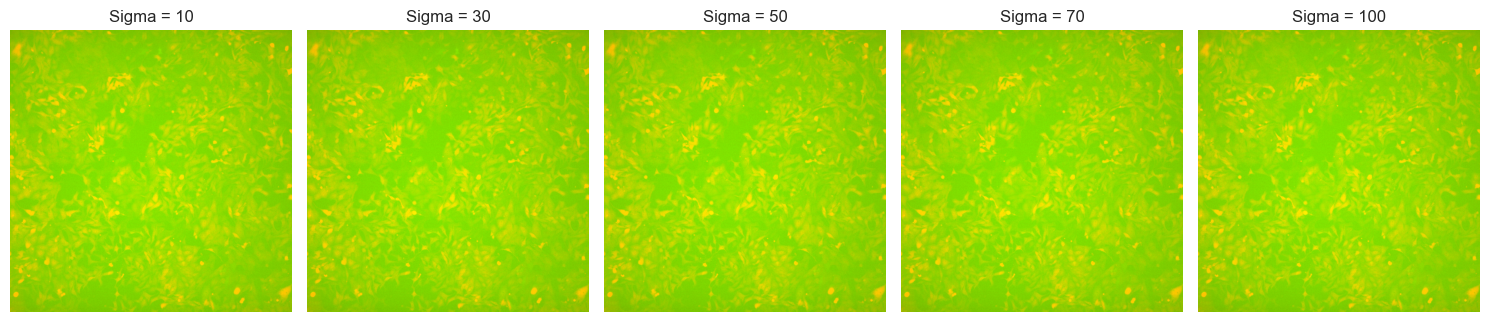

In [42]:

# Path to your image file
image_path = '/Users/elizabeth 1/Library/CloudStorage/Box-Box/Wu Lab/Project - 2024/Functional screening/240411 test in 6-well/Moe Effciency_Plate_1252/color composite_Elizabeth/percentage_normalization/Moe Effciency_A02_s1_w1_RGB.tif'  t

def display_images(images, titles):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, image, title in zip(axes, images, titles):
        ax.imshow(image)
        ax.set_title(f'Sigma = {title}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Load the image
image = io.imread(image_path)

# Define a range of sigma values to test
sigma_values = [10, 30, 50, 70, 100]

# Process the image with different sigma values
processed_images = [subtract_background(image, sigma) for sigma in sigma_values]

# Display all the processed images with their corresponding sigma values
display_images(processed_images, sigma_values)

In [53]:
sigma = 1000

# Subtract background from R and G channels
image_r_no_bg = image[:, :, 0] - gaussian(image[:, :, 0], sigma=sigma)
image_g_no_bg = image[:, :, 1] - gaussian(image[:, :, 1], sigma=sigma)

# Clip values to ensure they are within 0-255 range after subtraction
image_r_no_bg = np.clip(image_r_no_bg, 0, 255)
image_g_no_bg = np.clip(image_g_no_bg, 0, 255)

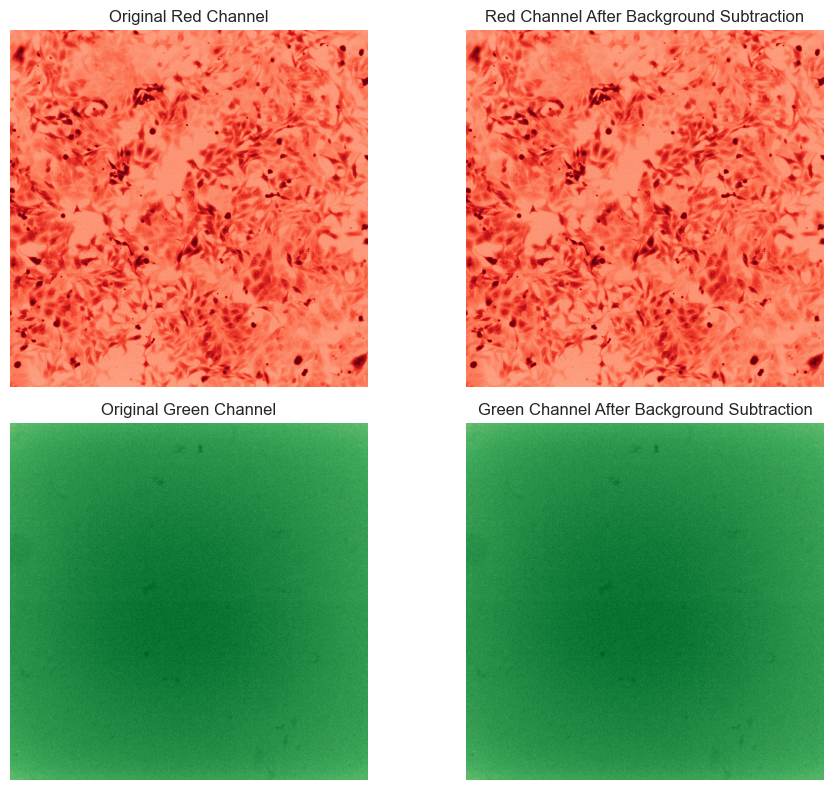

In [54]:

# Visualize the results
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

ax[0, 0].imshow(image[:, :, 0], cmap='Reds')
ax[0, 0].set_title('Original Red Channel')
ax[0, 0].axis('off')

ax[0, 1].imshow(image_r_no_bg, cmap='Reds')
ax[0, 1].set_title('Red Channel After Background Subtraction')
ax[0, 1].axis('off')

ax[1, 0].imshow(image[:, :, 1], cmap='Greens')
ax[1, 0].set_title('Original Green Channel')
ax[1, 0].axis('off')

ax[1, 1].imshow(image_g_no_bg, cmap='Greens')
ax[1, 1].set_title('Green Channel After Background Subtraction')
ax[1, 1].axis('off')

plt.tight_layout()
plt.show()


In [46]:
img_r = image[:, :, 0]
img_g = image[:, :, 1]
print(img_r==image_r_no_bg)
print(img_g==image_g_no_bg)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [ ]:

# Specify the input and output directories
input_directory = directory

output_directory = os.path.join(output_directory, 'percentage_normalization', 'background_subtraction')  # Change this to your desired output folder path

process_images(input_directory, output_directory)


**Scratch**

In [37]:
# Load the image
image = io.imread(image_path)

# Print the shape of the image to check dimensions
print("Image dimensions:", image.shape)

Image dimensions: (2160, 2160, 3)
